# Import Data and Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the cleaned dataset
file_path = "/content/drive/MyDrive/Final Project/data/US_Accidents_Sample.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Confirm successful load
print(df.head())


Mounted at /content/drive
   Severity  Start_Time    End_Time  Start_Lat  Start_Lng  End_Lat  End_Lng  \
0         3  1454910360  1454929200  39.865147 -84.058723  -9999.0  -9999.0   
1         2  1454911679  1454913479  39.928059 -82.831184  -9999.0  -9999.0   
2         2  1454914167  1454915967  39.063148 -84.032608  -9999.0  -9999.0   
3         3  1454916214  1454918014  39.747753 -84.205582  -9999.0  -9999.0   
4         2  1454917147  1454918947  39.627781 -84.188354  -9999.0  -9999.0   

   Distance(mi)  Weather_Timestamp  Temperature(F)  ...  \
0          0.01         1454911080            36.9  ...   
1          0.01         1454910660            37.9  ...   
2          0.01         1454914560            36.0  ...   
3          0.01         1454917080            35.1  ...   
4          0.01         1454917980            36.0  ...   

   Wind_Chill(F)_Missing  End_Lng_Missing  End_Lat_Missing  \
0                      1                1                1   
1                   

# Dataset Preparation

In [2]:
# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Ensure all classes are represented in training and validation sets
# Separate each class
class_groups = [df[df['Severity'] == i] for i in range(1, 5)]

# Take at least one sample from each class for training and validation
train_class_samples = [group.sample(n=1, random_state=42) for group in class_groups]
val_class_samples = [group.sample(n=1, random_state=42) for group in class_groups]

# Remove these samples from the main dataset
remaining_df = df.drop(pd.concat(train_class_samples + val_class_samples).index)

# Split remaining data into train and validation
train_size = int(0.8 * len(remaining_df))
train_df = pd.concat([remaining_df[:train_size], pd.concat(train_class_samples)])
val_df = pd.concat([remaining_df[train_size:], pd.concat(val_class_samples)])

# Shuffle final training and validation sets
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target
X_train = train_df.drop(columns=['Severity'])
y_train_raw = train_df['Severity']  # Keep raw labels for class weights
X_val = val_df.drop(columns=['Severity'])
y_val_raw = val_df['Severity']  # Keep raw labels for validation

# One-hot encode the target variable
y_train = to_categorical(y_train_raw - 1, num_classes=4)  # Subtract 1 to make labels 0-indexed
y_val = to_categorical(y_val_raw - 1, num_classes=4)


# Compute class weights to account for the imbalanced dataset

As discussed in other parts of this project, the dataset is skewed towards medium-intensity accidents. Compute some weights to ensure that this is not an issue in training our models.

In [3]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Use raw scalar labels for class weight computation
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_raw),  # Pass raw labels
    y=y_train_raw                    # Pass raw labels
)

# Convert the result to a dictionary for model compatibility
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights)


Class Weights: {0: 250.0, 1: 0.425531914893617, 2: 0.6090133982947625, 3: 250.0}


In [4]:
for i, group in enumerate(class_groups, start=1):
    print(f"Class {i} size:", len(group))


Class 1 size: 4
Class 2 size: 2938
Class 3 size: 2053
Class 4 size: 5


# Normalize Input Data

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Baseline Model - Logistic Regression

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2996 - loss: 1.7222 - val_accuracy: 0.3516 - val_loss: 1.4175
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3651 - loss: 1.3883 - val_accuracy: 0.4622 - val_loss: 1.2033
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4875 - loss: 1.1877 - val_accuracy: 0.5747 - val_loss: 1.0753
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5858 - loss: 1.0698 - val_accuracy: 0.6016 - val_loss: 0.9907
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6246 - loss: 0.9876 - val_accuracy: 0.6046 - val_loss: 0.9314
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6270 - loss: 0.9254 - val_accuracy: 0.6215 - val_loss: 0.8876
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6448 - loss: 0.8836 - val_accuracy: 0.6245 - val_loss: 0.8509
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6457 - loss: 0.8638 - val_accuracy: 0.

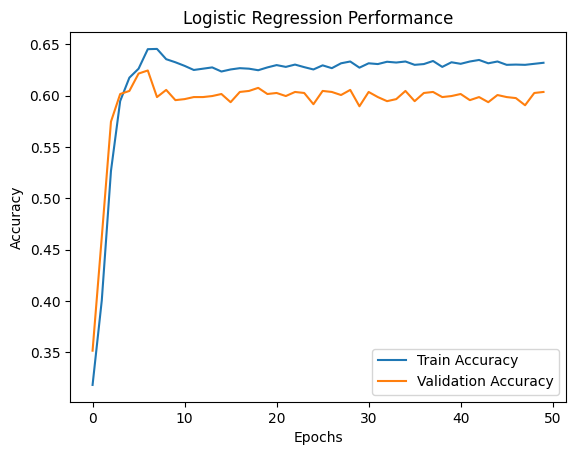

Validation Accuracy (Logistic Regression): 60.36%


In [7]:
# Logistic regression baseline model
logistic_model = Sequential([
    Dense(4, activation='softmax', input_shape=(X_train.shape[1],))
])

# Compile the model
logistic_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_logistic = logistic_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    verbose=1,
    # class_weight=smoothed_class_weights
)

# Plot training and validation accuracy
plt.plot(history_logistic.history['accuracy'], label='Train Accuracy')
plt.plot(history_logistic.history['val_accuracy'], label='Validation Accuracy')
plt.title('Logistic Regression Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the baseline model
baseline_results = logistic_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy (Logistic Regression): {baseline_results[1] * 100:.2f}%")

# Experimenting with Different Architectures

Epoch 1/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4772 - loss: 1.8113 - val_accuracy: 0.4622 - val_loss: 1.2764
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5043 - loss: 1.3891 - val_accuracy: 0.4701 - val_loss: 1.2563
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4950 - loss: 1.3873 - val_accuracy: 0.4851 - val_loss: 1.2416
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4986 - loss: 1.4159 - val_accuracy: 0.4920 - val_loss: 1.2292
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5104 - loss: 1.1774 - val_accuracy: 0.5090 - val_loss: 1.2146
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5407 - loss: 0.9228 - val_accuracy: 0.5120 - val_loss: 1.2025
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5390 - loss: 1.4939 - val_accuracy: 0.5179 - val_loss: 1.1884
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5520 - loss: 1.2423 - val_accu

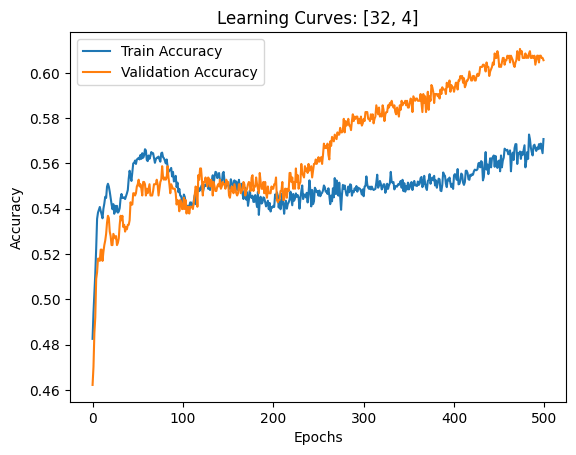

Epoch 1/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0258 - loss: 1.2437 - val_accuracy: 0.0568 - val_loss: 1.5405
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0566 - loss: 1.5114 - val_accuracy: 0.1285 - val_loss: 1.4942
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1171 - loss: 1.2315 - val_accuracy: 0.2032 - val_loss: 1.4738
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1929 - loss: 1.1463 - val_accuracy: 0.2341 - val_loss: 1.4600
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2267 - loss: 1.0924 - val_accuracy: 0.2629 - val_loss: 1.4469
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2476 - loss: 1.3674 - val_accuracy: 0.2709 - val_loss: 1.4459
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2413 - loss: 1.1660 - val_accuracy: 0.2699 - val_loss: 1.4457
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2328 - loss: 1.5337 - val_accu

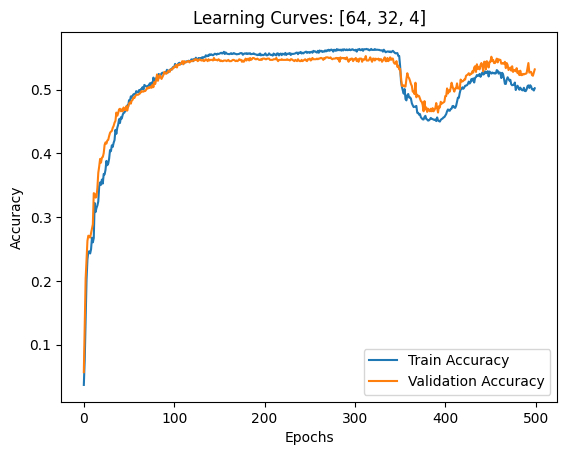

Epoch 1/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0047 - loss: 1.4951 - val_accuracy: 0.0289 - val_loss: 1.4851
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0464 - loss: 1.8140 - val_accuracy: 0.1026 - val_loss: 1.4514
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1327 - loss: 1.3363 - val_accuracy: 0.1404 - val_loss: 1.4447
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1593 - loss: 0.9138 - val_accuracy: 0.1504 - val_loss: 1.4518
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1549 - loss: 1.1846 - val_accuracy: 0.1554 - val_loss: 1.4632
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1679 - loss: 1.4590 - val_accuracy: 0.1703 - val_loss: 1.4612
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1779 - loss: 1.6144 - val_accuracy: 0.1723 - val_loss: 1.4672
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1879 - loss: 1.0274 - val_accu

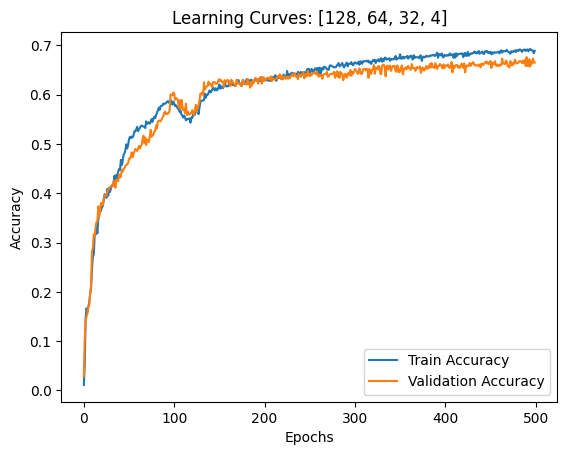

Epoch 1/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3635 - loss: 1.2649 - val_accuracy: 0.5329 - val_loss: 1.3430
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5218 - loss: 1.2739 - val_accuracy: 0.5727 - val_loss: 1.3145
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5713 - loss: 1.2430 - val_accuracy: 0.5807 - val_loss: 1.2959
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5589 - loss: 1.6804 - val_accuracy: 0.5886 - val_loss: 1.2717
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5643 - loss: 1.2916 - val_accuracy: 0.5857 - val_loss: 1.2559
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5675 - loss: 1.1908 - val_accuracy: 0.5787 - val_loss: 1.2300
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5540 - loss: 1.2880 - val_accuracy: 0.5707 - val_loss: 1.2227
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5390 - loss: 1.2356 - val_accu

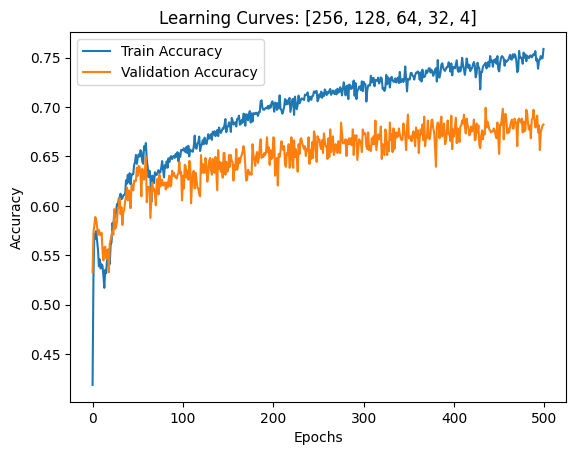

Epoch 1/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3736 - loss: 1.4484 - val_accuracy: 0.4133 - val_loss: 1.3421
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4208 - loss: 1.3894 - val_accuracy: 0.4183 - val_loss: 1.3054
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4363 - loss: 0.9648 - val_accuracy: 0.4661 - val_loss: 1.3011
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4607 - loss: 0.8753 - val_accuracy: 0.3725 - val_loss: 1.3213
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3499 - loss: 1.5585 - val_accuracy: 0.4024 - val_loss: 1.3011
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3749 - loss: 1.4124 - val_accuracy: 0.3606 - val_loss: 1.3075
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3125 - loss: 1.0762 - val_accuracy: 0.3546 - val_loss: 1.3288
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3166 - loss: 1.5004 - val_ac

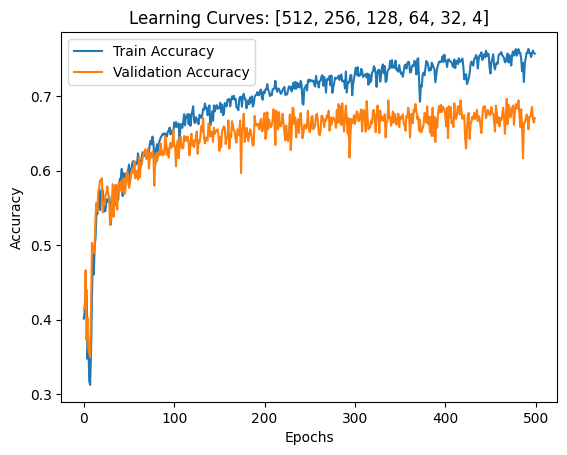

          Architecture  Train Accuracy  Validation Accuracy  Train Loss  \
0                 32-4         0.56850             0.605578    0.753569   
1              64-32-4         0.50450             0.531873    0.741525   
2          128-64-32-4         0.69100             0.665339    0.610632   
3      256-128-64-32-4         0.75650             0.682271    0.497554   
4  512-256-128-64-32-4         0.76425             0.670319    0.458454   

   Validation Loss  
0         0.761999  
1         0.749320  
2         0.673685  
3         0.736259  
4         0.731664  


In [8]:
from tensorflow.keras.optimizers import Adam

# Experimenting with Neural Network Architectures
architectures = [
    [32, 4],       # Small network
    [64, 32, 4],   # Medium network
    [128, 64, 32, 4],   # Large network
    [256, 128, 64, 32, 4],   # XL network
    [512 ,256, 128, 64, 32, 4]   # XXL network
]

results = []

for architecture in architectures:
    # Define the model
    model = Sequential()
    model.add(Dense(architecture[0], activation='relu', input_shape=(X_train.shape[1],)))

    for neurons in architecture[1:]:
        model.add(Dense(neurons, activation='relu'))

    model.add(Dense(4, activation='softmax'))  # Output layer

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Checkpoint
    checkpoint = ModelCheckpoint(f"model_{'-'.join(map(str, architecture))}.keras",
                                  save_best_only=True, monitor='val_accuracy', mode='max')

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=500,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint],
        verbose=1,
        class_weight=class_weights
    )

    # Evaluate the model
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

    # Store results
    results.append({
        'Architecture': '-'.join(map(str, architecture)),
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Train Loss': train_loss,
        'Validation Loss': val_loss
    })

    # Plot learning curves
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Learning Curves: {architecture}")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Convert results to DataFrame and save
results_df = pd.DataFrame(results)
results_df.to_csv(f"/content/drive/MyDrive/Final Project/Phase 3/results.csv", index=False)
print(results_df)


# Evaluation Metrics

In [9]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model("model_128-64-32-4.keras")
y_pred = best_model.predict(X_val).argmax(axis=1)
y_true = y_val.argmax(axis=1)

# Classification report
from sklearn.metrics import classification_report

# Check unique classes
unique_classes = np.unique(y_true)
print("Unique classes in y_true:", unique_classes)
print("Unique classes in y_pred:", np.unique(y_pred))

target_names = [f"Severity {i+1}" for i in unique_classes]

# Generate classification report
print(classification_report(y_true, y_pred, target_names=target_names))



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Unique classes in y_true: [0 1 2 3]
Unique classes in y_pred: [0 1 2 3]
              precision    recall  f1-score   support

  Severity 1       0.25      1.00      0.40         1
  Severity 2       0.77      0.66      0.71       589
  Severity 3       0.60      0.70      0.65       412
  Severity 4       0.10      0.50      0.17         2

    accuracy                           0.68      1004
   macro avg       0.43      0.72      0.48      1004
weighted avg       0.70      0.68      0.68      1004



# Include Output Variable as Input

In [10]:
# Ensure y_train_raw and y_val_raw are reshaped correctly for concatenation
y_train_raw = y_train_raw.values.reshape(-1, 1)  # Convert to a column vector
y_val_raw = y_val_raw.values.reshape(-1, 1)      # Convert to a column vector

# Concatenate the new feature to the existing feature set
X_train = np.concatenate([X_train, y_train_raw], axis=1)
X_val = np.concatenate([X_val, y_val_raw], axis=1)

# Print the new shape of the training data
print(f"Updated X_train shape: {X_train.shape}")

Updated X_train shape: (4000, 42)


# Train Models Again on Updated Data Frame, with Output Variable as Input.

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4069 - loss: 2.0035 - val_accuracy: 0.6215 - val_loss: 1.2739
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6519 - loss: 1.0307 - val_accuracy: 0.6006 - val_loss: 1.2023
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6548 - loss: 1.2406 - val_accuracy: 0.6195 - val_loss: 1.1461
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5854 - loss: 1.7702 - val_accuracy: 0.6554 - val_loss: 1.1187
Epoch 5/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6864 - loss: 1.3696 - val_accuracy: 0.6355 - val_loss: 1.0772
Epoch 6/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6664 - loss: 1.3537 - val_accuracy: 0.6584 - val_loss: 1.0583
Epoch 7/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6866 - loss: 1.3102 - val_accuracy: 0.6962 - val_loss: 1.0567
Epoch 8/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6935 - loss: 1.5356 - val_accuracy: 0.6624

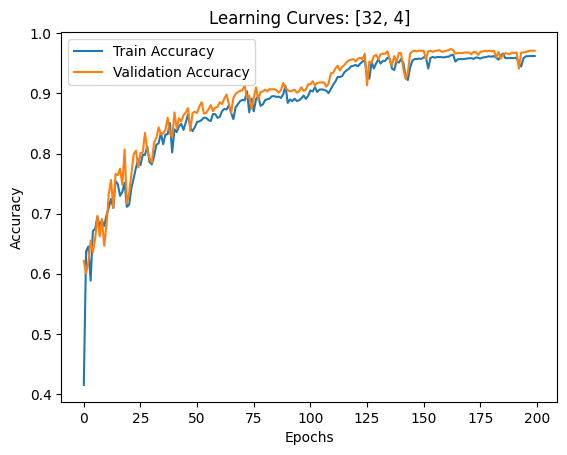

Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5224 - loss: 1.4097 - val_accuracy: 0.5538 - val_loss: 1.2493
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5907 - loss: 1.1898 - val_accuracy: 0.5667 - val_loss: 1.1289
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6438 - loss: 1.2366 - val_accuracy: 0.7181 - val_loss: 0.8369
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7341 - loss: 0.7868 - val_accuracy: 0.7032 - val_loss: 0.8733
Epoch 5/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7087 - loss: 0.8179 - val_accuracy: 0.8008 - val_loss: 0.6783
Epoch 6/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7330 - loss: 1.2982 - val_accuracy: 0.8098 - val_loss: 0.6239
Epoch 7/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8187 - loss: 0.7330 - val_accuracy: 0.8277 - val_loss: 0.6291
Epoch 8/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8230 - loss: 0.8608 - val_accu

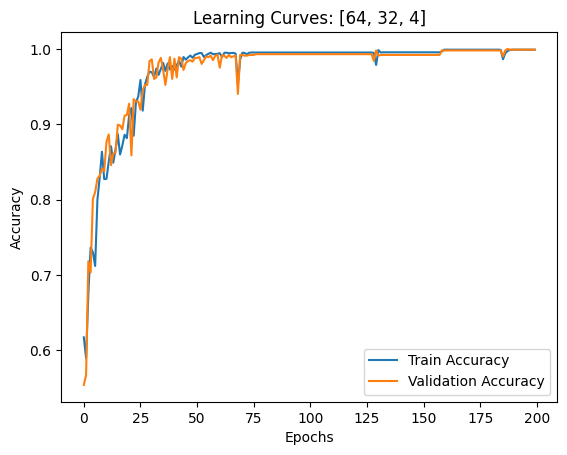

Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6152 - loss: 1.4252 - val_accuracy: 0.7341 - val_loss: 0.9266
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6880 - loss: 1.0734 - val_accuracy: 0.6992 - val_loss: 0.9206
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6539 - loss: 1.5301 - val_accuracy: 0.5986 - val_loss: 0.8892
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6387 - loss: 1.1093 - val_accuracy: 0.6663 - val_loss: 0.7709
Epoch 5/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6889 - loss: 1.1362 - val_accuracy: 0.8307 - val_loss: 0.5640
Epoch 6/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7714 - loss: 0.7821 - val_accuracy: 0.7729 - val_loss: 0.6259
Epoch 7/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7804 - loss: 0.6549 - val_accuracy: 0.6633 - val_loss: 0.8224
Epoch 8/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7114 - loss: 0.9889 - val_accu

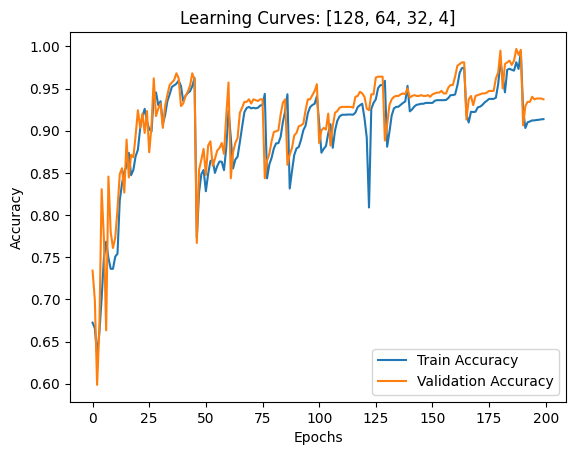

Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5066 - loss: 1.0938 - val_accuracy: 0.6235 - val_loss: 1.2822
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5858 - loss: 1.6390 - val_accuracy: 0.6106 - val_loss: 1.0027
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7732 - loss: 1.4071 - val_accuracy: 0.5986 - val_loss: 1.2674
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5927 - loss: 1.3490 - val_accuracy: 0.7092 - val_loss: 1.1606
Epoch 5/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7120 - loss: 1.2762 - val_accuracy: 0.7271 - val_loss: 1.1469
Epoch 6/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7312 - loss: 1.5811 - val_accuracy: 0.7420 - val_loss: 1.1399
Epoch 7/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7177 - loss: 1.7151 - val_accuracy: 0.7500 - val_loss: 1.1340
Epoch 8/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7610 - loss: 1.4038 - val_accu

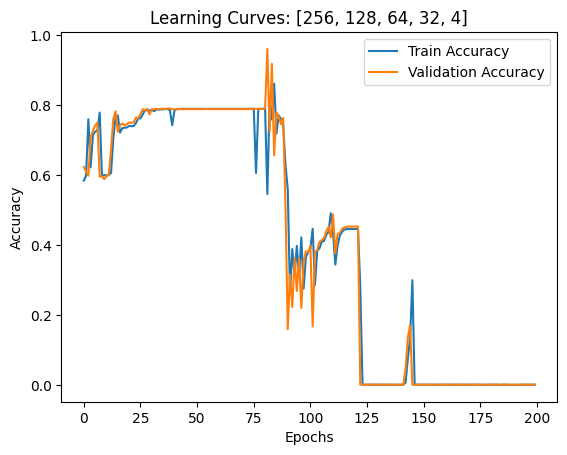

Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6939 - loss: 2.2599 - val_accuracy: 0.7948 - val_loss: 0.8947
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9055 - loss: 1.2849 - val_accuracy: 0.9373 - val_loss: 0.4940
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9132 - loss: 1.1200 - val_accuracy: 0.9382 - val_loss: 0.4926
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9486 - loss: 0.4656 - val_accuracy: 0.9193 - val_loss: 0.4685
Epoch 5/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9358 - loss: 0.6128 - val_accuracy: 0.9622 - val_loss: 0.2887
Epoch 6/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9436 - loss: 0.6456 - val_accuracy: 0.9422 - val_loss: 0.3852
Epoch 7/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9444 - loss: 0.4194 - val_accuracy: 0.9243 - val_loss: 0.1943
Epoch 8/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8018 - loss: 0.8979 - val_ac

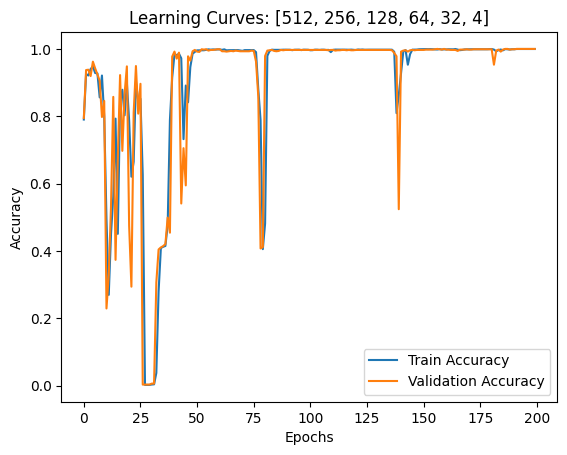

          Architecture  Train Accuracy  Validation Accuracy  Train Loss  \
0                 32-4         0.96225             0.971116    0.112759   
1              64-32-4         0.99900             0.999004    0.003469   
2          128-64-32-4         0.91375             0.937251    0.255067   
3      256-128-64-32-4         0.00100             0.000996    1.393333   
4  512-256-128-64-32-4         0.99975             1.000000    0.002621   

   Validation Loss  
0         0.109288  
1         0.004395  
2         0.202202  
3         1.393323  
4         0.004215  


In [11]:
# Initialize results list for storing metrics
results = []

for architecture in architectures:
    # Define the model
    model = Sequential()
    model.add(Dense(architecture[0], activation='relu', input_shape=(X_train.shape[1],)))

    for neurons in architecture[1:]:
        model.add(Dense(neurons, activation='relu'))

    model.add(Dense(4, activation='softmax'))  # Output layer

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Checkpoint
    checkpoint = ModelCheckpoint(f"model_{'-'.join(map(str, architecture))}.keras",
                                  save_best_only=True, monitor='val_accuracy', mode='max')

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=200,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint],
        verbose=1,
        class_weight=class_weights
    )

    # Evaluate the model
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

    # Store results
    results.append({
        'Architecture': '-'.join(map(str, architecture)),
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Train Loss': train_loss,
        'Validation Loss': val_loss
    })

    # Plot learning curves
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Learning Curves: {architecture}")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Convert results to DataFrame and save
results_df = pd.DataFrame(results)
results_df.to_csv(f"/content/drive/MyDrive/Final Project/Phase 3/results_with_output_as_input.csv", index=False)
print(results_df)


# Retrain a Model *Without* a Feedback Loop

In [12]:
# Revert X_train and X_val to their original state
X_train = train_df.drop(columns=['Severity'])
X_val = val_df.drop(columns=['Severity'])

# Normalize the features again
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [16]:
# Define the model
model = Sequential([
    Dense(128-64-32-4, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, verbose=1, class_weight=class_weights)


Epoch 1/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4495 - loss: 1.3786 - val_accuracy: 0.6175 - val_loss: 0.9466
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6068 - loss: 1.0703 - val_accuracy: 0.5578 - val_loss: 0.9990
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5242 - loss: 1.0309 - val_accuracy: 0.5687 - val_loss: 0.8846
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5341 - loss: 0.8399 - val_accuracy: 0.5169 - val_loss: 1.0205
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5063 - loss: 0.8007 - val_accuracy: 0.4592 - val_loss: 1.0309
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4780 - loss: 1.0344 - val_accuracy: 0.5139 - val_loss: 0.9514
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4751 - loss: 1.0246 - val_accuracy: 0.5279 - val_loss: 0.9050
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4983 - loss: 0.6749 - val_accu

# Extract Weights and Build a Predictive Function

In [17]:
for i, layer in enumerate(model.layers):
    weights, biases = layer.get_weights()
    print(f"Layer {i}: Weights shape: {weights.shape}, Biases shape: {biases.shape}")

Layer 0: Weights shape: (41, 28), Biases shape: (28,)
Layer 1: Weights shape: (28, 64), Biases shape: (64,)
Layer 2: Weights shape: (64, 32), Biases shape: (32,)
Layer 3: Weights shape: (32, 4), Biases shape: (4,)


In [18]:
import numpy as np

def my_prediction_function(model, data):
    """
    Custom function to manually perform a forward pass through the trained model.

    Args:
        model: Trained Keras model.
        data: Input feature matrix.

    Returns:
        predictions: Model output probabilities for each class.
    """
    # Initialize the output as the input data
    output = data

    # Iterate through each layer in the model
    for layer in model.layers:
        # Get weights and biases for the current layer
        weights, biases = layer.get_weights()

        # Perform the linear transformation: output = X @ W + b
        output = np.dot(output, weights) + biases

        # Apply activation functions
        if layer.activation.__name__ == 'relu':
            output = np.maximum(0, output)  # ReLU activation
        elif layer.activation.__name__ == 'softmax':
            # Softmax activation for the output layer
            exp_output = np.exp(output)
            output = exp_output / np.sum(exp_output, axis=1, keepdims=True)
        elif layer.activation.__name__ == 'sigmoid':
            output = 1 / (1 + np.exp(-output))  # Sigmoid activation

    return output

In [19]:
# Get predictions from the trained model
model_predictions = model.predict(X_val)

# Get predictions from the custom function
custom_predictions = my_prediction_function(model, X_val)

# Check if they are nearly identical
are_predictions_close = np.allclose(model_predictions, custom_predictions, atol=1e-6)
print("Do the predictions match?", are_predictions_close)

# Optionally, print a few predictions for comparison
print("Model Predictions (First 5):", model_predictions[:5])
print("Custom Predictions (First 5):", custom_predictions[:5])


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Do the predictions match? True
Model Predictions (First 5): [[6.5131579e-32 9.9326348e-01 6.7364462e-03 8.0581503e-18]
 [3.0161260e-22 5.2810377e-01 4.7189626e-01 2.0288403e-14]
 [0.0000000e+00 3.4297802e-02 9.6570218e-01 0.0000000e+00]
 [1.5348965e-18 2.7707225e-01 7.2292763e-01 1.0200143e-12]
 [0.0000000e+00 9.9584663e-01 4.1533117e-03 0.0000000e+00]]
Custom Predictions (First 5): [[6.51309446e-32 9.93263552e-01 6.73644799e-03 8.05810616e-18]
 [3.01613098e-22 5.28103507e-01 4.71896493e-01 2.02885581e-14]
 [1.71082210e-50 3.42978445e-02 9.65702155e-01 3.52989862e-43]
 [1.53490227e-18 2.77072382e-01 7.22927618e-01 1.02001023e-12]
 [7.27069238e-58 9.95846677e-01 4.15332252e-03 8.65322460e-65]]


In [ ]:
%%shell
 jupyter nbconvert --to html "/content/drive/MyDrive/Final Project/Phase 3/Phase 3(v2).ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Final Project/Phase 3/Phase 3(v2).ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('metadata' was unexpected)

Failed validating 'additionalProperties' in stream:

On instance['cells'][12]['outputs'][0]:
{'metadata': {'tags': None},
 'name': 'stdout',
 'output_type': 'stream',
 'text': 'Epoch 1/500\n'}
[NbConvertApp] WARNING | Alternative text is missing on 11 image(s).
[NbConvertApp] Writing 1916116 bytes to /content/drive/MyDrive/Final Project/Phase 3/Phase 3(v2).html
